In [175]:
import models
from models.convert_pidinet import convert_pidinet
from edge_dataloader import  BSDS_Loader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import time
import torch
import torchvision
import numpy as np
import cv2
from utils import *

In [176]:
class Args:
    def __init__(self):
        self.ablation=False
        self.savedir='./data/table5_our'
        self.use_cuda=False
        self.model='pidinet_converted', 

        self.config='carv4'
        self.sa=True
        self.dil=True  
        self.evaluate_converted=True
#         self.datadir='./data/BSDS500cubs'
        self.datadir='./data/BSDS500Single'
        self.eta=0.3
        self.evaluate='./data/table5_our/save_models/checkpoint_007_.pth'
args=Args()        

### Extra functions

In [177]:

def create_mask(arr):
    max_val=np.max(arr)
    mask_threshold=int(0.975*max_val)
    print("mask_threshold",mask_threshold)
#     mask_threshold=200
    new_matrix=np.zeros(arr.shape)
    new_matrix[arr>mask_threshold]=255
    return new_matrix

def find_polyline_y(mask_array):
    up_points=[]
    down_points=[]    
    
    for col_num in range(mask_array.shape[1]):
        for row_num in range(mask_array.shape[0]):
            if mask_array[row_num][col_num]==255:
                break

        up_point=(row_num,col_num)
        for row_num in range(row_num+1,mask_array.shape[0]):
            if mask_array[row_num][col_num]==0:
                break
        down_point=(row_num-1,col_num)

        if down_point[0]>up_point[0]+1:
            up_points.append(up_point)
            down_points.append(down_point)


    return up_points,down_points


def find_best_polyline_y(up_points,down_points):
    up_points=np.array(up_points)
    down_points=np.array(down_points)

    

    mean_up_row_num=int(np.mean(up_points[:,0]))
    mean_down_row_num=int(np.mean(down_points[:,0]))
    to_remove=[]
    for i in range(up_points.shape[0]):
        if not(up_points[i][0]>mean_up_row_num-50 and up_points[i][0]<mean_up_row_num+50):
            to_remove.append(i)

    up_points=np.delete(up_points,to_remove,axis=0)
    down_points=np.delete(down_points,to_remove,axis=0)

    print(mean_up_row_num,mean_down_row_num)
    return up_points,down_points


In [178]:
running_file = os.path.join(args.savedir, '%s_running-%s.txt' \
            % (args.model, time.strftime('%Y-%m-%d-%H-%M-%S')))


### Create model

In [179]:
model=models.my_pidinet_converted(args.config,args.sa,args.dil)

At my_pidinet_converted 
{'layer0': 'cd', 'layer1': 'ad', 'layer2': 'rd', 'layer3': 'cv', 'layer4': 'cd', 'layer5': 'ad', 'layer6': 'rd', 'layer7': 'cv', 'layer8': 'cd', 'layer9': 'ad', 'layer10': 'rd', 'layer11': 'cv', 'layer12': 'cd', 'layer13': 'ad', 'layer14': 'rd', 'layer15': 'cv'}
initialization done


In [180]:
with open(running_file, 'w+') as f:
    checkpoint = load_checkpoint(args, f)


model.load_state_dict(convert_pidinet(checkpoint['state_dict'], args.config))

=> loading checkpoint from './data/table5_our/save_models/checkpoint_007_.pth'
model_filename ./data/table5_our/save_models/checkpoint_007_.pth
=> loaded checkpoint './data/table5_our/save_models/checkpoint_007_.pth' successfully
{'layer0': 'cd', 'layer1': 'ad', 'layer2': 'rd', 'layer3': 'cv', 'layer4': 'cd', 'layer5': 'ad', 'layer6': 'rd', 'layer7': 'cv', 'layer8': 'cd', 'layer9': 'ad', 'layer10': 'rd', 'layer11': 'cv', 'layer12': 'cd', 'layer13': 'ad', 'layer14': 'rd', 'layer15': 'cv'}


<All keys matched successfully>

### Get test dataset and dataloader

In [181]:

# test_dataset = BSDS_Loader(root=args.datadir, split="test", threshold=args.eta)
test_dataset = BSDS_Loader(root=args.datadir, split="test", threshold=args.eta)

Threshold for ground truth: 76.800000 on BSDS


In [182]:
test_loader = DataLoader(test_dataset, batch_size=12, num_workers=0, shuffle=False)

In [183]:
for imgs,labels in test_loader:
    print(labels)

('device_usg',)


### Create the running file

In [184]:
# running_file

In [185]:

def test(test_loader, model, epoch, running_file,args):

    print("Args are ",args)

    from PIL import Image
    import scipy.io as sio
    model.eval()

    if args.ablation:
        img_dir = os.path.join(args.savedir, 'eval_results_val', 'imgs_epoch_%03d' % (epoch - 1))
        mat_dir = os.path.join(args.savedir, 'eval_results_val', 'mats_epoch_%03d' % (epoch - 1))
    else:
        img_dir = os.path.join(args.savedir, 'eval_results', 'imgs_epoch_%03d' % (epoch - 1))
        mat_dir = os.path.join(args.savedir, 'eval_results', 'mats_epoch_%03d' % (epoch - 1))
    eval_info = '\nBegin to eval...\nImg generated in %s\n' % img_dir
    print(eval_info)
    running_file.write('\n%s\n%s\n' % (str(args), eval_info))
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    else:
        print('%s already exits, yes' % img_dir)
        #return
    if not os.path.exists(mat_dir):
        print("Creating folder",mat_dir)
        os.makedirs(mat_dir)

    for idx, (image, img_name) in enumerate(test_loader):
        print("Going for test loader batch",idx)
        img_name = img_name[0]
        with torch.no_grad():
            image = image.cuda() if args.use_cuda else image
            _, _, H, W = image.shape
            results = model(image)
            result = torch.squeeze(results[-1]).cpu().numpy()

        results_all = torch.zeros((len(results), 1, H, W))
        for i in range(len(results)):
          results_all[i, 0, :, :] = results[i]
        print("Completed one batch")
        print("going to save the segmented image as ",img_name)
        torchvision.utils.save_image(1-results_all, 
                os.path.join(img_dir, "%s.jpg" % img_name))
        sio.savemat(os.path.join(mat_dir, '%s.mat' % img_name), {'img': result})
        result = Image.fromarray((result * 255).astype(np.uint8))
        print(np.asarray(result))
        print("min, max",np.min(np.asarray(result)),np.max(np.asarray(result)))
        plt.hist(np.asarray(result))
        plt.show()

        # find the white line

        mask_array=create_mask(np.asarray(result))
        mask_image = Image.fromarray(mask_array.astype(np.uint8))
        mask_image.save(os.path.join(img_dir, "%s_mask.png" % img_name))

        up_points,down_points=find_polyline_y(mask_array)
        up_points,down_points=find_best_polyline_y(up_points,down_points)




        print("top left",up_points[0])
        print("bottom_right",down_points[-1])


        


        result.save(os.path.join(img_dir, "%s.png" % img_name))
        image = cv2.imread(os.path.join(img_dir, "%s.png" % img_name))
        color = (0, 0, 255)
        fcolor = (255, 0, 0)
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1


        # Line thickness of 2 px
        thickness = 3
        calculated_thickness=[]
        for i in range(up_points.shape[0]):
            up_point=(up_points[i][1],up_points[i][0])
            down_point=(down_points[i][1],down_points[i][0])
            calculated_thickness.append(down_points[i][0]-up_points[i][0])
            image=cv2.line(image, up_point, down_point, color, thickness) 
        average_thickness=round(np.mean(np.array(calculated_thickness)),2)
        image = cv2.putText(image, "th:"+str(average_thickness), (up_points[0][1]-15,up_points[0][0]-15), font, 
                   fontScale, fcolor, thickness, cv2.LINE_AA)

        
        cv2.imwrite(os.path.join(img_dir, "%s_box.png" % img_name),image)

        # result_array=np.asarray(image)
        # print("result shsape is ",result_array.shape)


        runinfo = "Running test [%d/%d]" % (idx + 1, len(test_loader))
        print(runinfo)
        running_file.write('%s\n' % runinfo)
    running_file.write('\nDone\n')

In [186]:
running_file

"./data/table5_our/('pidinet_converted',)_running-2023-04-19-20-59-26.txt"

Args are  <__main__.Args object at 0x7fc52b6a5250>

Begin to eval...
Img generated in ./data/table5_our/eval_results/imgs_epoch_007

./data/table5_our/eval_results/imgs_epoch_007 already exits, yes
Going for test loader batch 0
Completed one batch
going to save the segmented image as  device_usg
[[85 85 85 ... 85 85 85]
 [85 53 17 ... 14 50 85]
 [85 17  0 ...  0 14 85]
 ...
 [85 15  0 ...  4 35 85]
 [85 51 15 ... 35 65 85]
 [85 85 85 ... 85 85 85]]
min, max 0 95


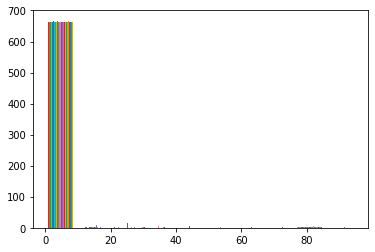

mask_threshold 92
158 160
top left [ 158 1079]
bottom_right [ 160 1081]
Running test [1/1]


In [187]:
epoch=8
with open(running_file, 'w+') as f:
    test(test_loader, model, epoch, f,args)


In [188]:
test_dataset.__dir__()

['root',
 'split',
 'threshold',
 'transform',
 'filelist',
 '__module__',
 '__doc__',
 '__init__',
 '__len__',
 '__getitem__',
 '__parameters__',
 '__add__',
 '__orig_bases__',
 '__dict__',
 '__weakref__',
 '__slots__',
 '__new__',
 '__class_getitem__',
 '__init_subclass__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [189]:
test_dataset.filelist

['my_data/test_img/device_usg.jpeg']

In [190]:
from PIL import Image

In [191]:
im=Image.open("/Users/ashhadulislam/projects/hbku/misc/mpt/Maryam_Team/code_FlaskServer/data/table5_our/eval_results/imgs_epoch_007/im1.jpg")
np.asarray(im)

print(np.min(np.asarray(im)),np.max(np.asarray(im)))

7 255


In [192]:
im=Image.open("/Users/ashhadulislam/projects/hbku/misc/mpt/Maryam_Team/code_FlaskServer/data/table5_our/eval_results/imgs_epoch_007/device_usg.jpg")
np.asarray(im)

print(np.min(np.asarray(im)),np.max(np.asarray(im)))

158 255


In [193]:
240/246

0.975609756097561